# Project Description

## Motivation


<i><b>For Jan</b>: Insert business value</i>

## Data Source

<i><b>For Jan</b>: Insert write up</i>

Note: https://www.sciencedirect.com/science/article/abs/pii/S0379073824001944

## Main Problem

<i><b>For Jan</b>: Insert main problem</i>

Sample: What models can be recommended that provides the highest accuracy depending on the resolution level?

## Limitations

In the study "YHP: Y-chromosome Haplogroup Predictor for predicting male lineages based on Y-STRs", the researchers classified the different haplogroups into 18 resolutions, wherein each resolution was used to train and test the different machine learning models. Grouping the haplogroups into resolutions requires further research to ensure correctness of classification. 

With this in mind, this study no longer classified the haplogroups into resolution. Instead, the entire data set was utilized in training and testing machine learning models.

# Methodology

Step 1. Identify the Business Problem

Step 2. Identify the Machine Learning Task

Step 3. Identify Key Evaluation Metrics

Step 4. Build and Test Machine Learning Models

## 1. Identify the Business Problem

<i><b>For Jan</b>: Rephrase motivation and main problem</i>

## 2. Identify the Machine Learning Task

What will the machine learning model do?
- Goal is to predict the class label (i.e. haplogroup) choice from a predefined list of states (i.e. 27 Y-STRs)

Classification Problem
- Input: Y-STRs (e.g Column DYS576, Column DYS627)
- Output: Haplogroups (i.e. Column haplogroup)

Since this is a classification problem, the following models will be utilized.
1. KNN
2. LDA
3. Gaussian Naive Bayes
4. Decision Tree
5. Random Forest
6. Gradient Boosting

For KNN, scaling will be applied during the data preprocessing to help with faster convergence, equal feature contribution, and improved performance [2][3].

Note that Logistic Regression (L1, L2) will not be used because of the assumption of linearity between the dependent variable and the independent variables [4]. Given that the dataset has overlapping classes as seen in 4.2 EDA, it will be difficult to establish the linearity between the target and the features.

SVM will also not be used because the dataset has overlapping classes [5]. As an example, plotting two of the features (i.e. DYS627 and DYS576) show overlaps between the four haplogroups (i.e. R1a1a1b2a2, O2a2b1a1a1, O2a2a1, O2a2b1a2a1) as seen in 4.2 EDA

## 3. Identify Key Evaluation Metrics

<i><b>For Jan</b>: What evaluation metric will we use? If we will use Accuracy, explain why we will use Accuracy as the evalutation metric.

We also need to look for any industry benchmarks on Accuracy. Otherwise, we can proceed to using PCC.</i>

Evaluation Metrics: Classification
- Accuracy: use when the goal is to minimize the overall error state
- Precision: use when the cost of false positives is high
- Recall: use when the cost of false negatives is high
- F1-score: use if you want to optimize precision and recall at the same time

### PCC for Benchmark

## 4. Build and Test Machine Learning Models

In [10]:
import numpy as np
import pandas as pd
import math
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Gradient Boosting

In [11]:
# Step 1. Load dataset
df = pd.read_excel('Supplemental Processed Data Set.xlsx', sheet_name='S Table 1', skiprows=1)
# Step 2. Fill NaN values
df = df.ffill()
# Step 3. Split haplotype into separate columns
df = pd.concat([df, df['haplotype'].str.replace('[', '').str.replace(']', '').str.split(',', expand=True)], axis=1)
YSTRs = {0: "DYS576", 1: "DYS389 I", 2: "DYS635", 3: "DYS389 II", 4: "DYS627", 5: "DYS460", 6: "DYS458",
                 7: "DYS19", 8: "Y-GATA-H4", 9: "DYS448", 10: "DYS391", 11: "DYS456", 12: "DYS390", 13: "DYS438", 
                 14: "DYS392", 15: "DYS518", 16: "DYS570", 17: "DYS437", 18: "DYS385a", 19: "DYS385b", 20: "DYS449", 
                 21: "DYS393", 22: "DYS439", 23: "DYS481", 24: "DYS576a", 25: "DYS576b", 26: "DYS533"
}

df = df.rename(columns=YSTRs)
df = df.drop(columns=['haplotype'])
df

,haplogroup,number of haplotypes,total frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,DYS437,DYS385a,DYS385b,DYS449,DYS393,DYS439,DYS481,DYS576a,DYS576b,DYS533
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,14.0,11.0,19.0,30.0,14.0,12.0,24.0,36.0,39.0,12.0
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,14.0,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,14.0,11.0,19.0,30.0,14.0,12.0,23.0,37.0,38.0,12.0
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,14.0,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,16.0,14.0,18.0,32.0,11.0,13.0,23.0,35.0,37.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,14.0,13.0,13.0,31.0,13.0,11.0,25.0,37.0,40.0,11.0
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,14.0,12.0,19.0,31.0,12.0,12.0,28.0,36.0,38.0,11.0
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,14.0,12.0,19.0,33.0,12.0,12.0,26.0,36.0,39.0,11.0
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,14.0,12.0,18.0,29.0,14.0,12.0,23.0,37.0,39.0,11.0


In [12]:
# ======================================================
# 3. MUTATION-AWARE FEATURE ENGINEERING (Final Extended + Normalized)
# ======================================================

# ------------------------------------------------------
# Define Yfiler Plus mutation-rate groups (canonical names)
# ------------------------------------------------------
fast_loci = ["DYS570", "DYS576", "DYS458", "DYS449", "DYS627", "DYS481"]
intermediate_loci = [
    "DYS385a", "DYS385b", "DYS533", "DYS19", "DYS391",
    "DYS518", "DYS635", "DYS390", "DYS392", "DYS393"
]
slow_loci = [
    "DYS438", "DYS437", "DYS439", "DYS389I", "DYS389II",
    "DYS460", "DYS456", "Y_GATA_H4", "DYS448"
]

# ------------------------------------------------------
# Identify available STR columns
# ------------------------------------------------------
available_str_cols = [c for c in df.columns if any(k in c for k in ["DYS", "Y_GATA", "YGATA"])]
print(f"Detected {len(available_str_cols)} STR columns:", available_str_cols)

# ------------------------------------------------------
# Adjust loci lists to only include those present
# ------------------------------------------------------
fast_loci = [l for l in fast_loci if l in df.columns]
intermediate_loci = [l for l in intermediate_loci if l in df.columns]
slow_loci = [l for l in slow_loci if l in df.columns]
str_cols = list(set(fast_loci + intermediate_loci + slow_loci))

print(f"\nUsing {len(str_cols)} STR loci after filtering:")
print(str_cols)

# ------------------------------------------------------
# Ensure numeric STR data
# ------------------------------------------------------
df[str_cols] = df[str_cols].apply(pd.to_numeric, errors="coerce")

# ------------------------------------------------------
# Remove haplogroups with only one sample
# ------------------------------------------------------
hap_col = df.columns[0]
counts = df[hap_col].value_counts()
df = df[df[hap_col].isin(counts[counts > 1].index)].copy()

# ------------------------------------------------------
# Compute haplogroup centroids
# ------------------------------------------------------
centroids = df.groupby(hap_col)[str_cols].mean()

# ------------------------------------------------------
# L1 distance to haplogroup centroid
# ------------------------------------------------------
def l1_to_centroid(row):
    hg = row[hap_col]
    if hg not in centroids.index:
        return np.nan
    centroid = centroids.loc[hg]
    return np.abs(row[str_cols] - centroid).sum()

df["l1_centroid"] = df.apply(l1_to_centroid, axis=1)

# ------------------------------------------------------
# Weighted L1 (fast=3, intermediate=2, slow=1)
# ------------------------------------------------------
weights = {l: 3 for l in fast_loci}
weights.update({l: 2 for l in intermediate_loci})
weights.update({l: 1 for l in slow_loci})

df["weighted_l1_centroid"] = df.apply(
    lambda r: sum(
        abs(r[c] - centroids.loc[r[hap_col], c]) * weights.get(c, 2)
        for c in str_cols if c in centroids.columns
    ),
    axis=1
)

# ------------------------------------------------------
# Global allele statistics
# ------------------------------------------------------
df["allele_sum"] = df[str_cols].sum(axis=1)
df["allele_var"] = df[str_cols].var(axis=1)
df["allele_mean"] = df[str_cols].mean(axis=1)
df["allele_std"] = df[str_cols].std(axis=1)

# ------------------------------------------------------
# Median-based and skewness proxies
# ------------------------------------------------------
df["allele_median"] = df[str_cols].median(axis=1)
df["median_deviation"] = df["allele_median"] - df["allele_mean"]
df["skewness_proxy"] = (df["allele_mean"] - df["allele_median"]) / (df["allele_std"] + 1e-9)

# ------------------------------------------------------
# Mutation-category-specific variation
# ------------------------------------------------------
if fast_loci:
    df["fast_var"] = df[fast_loci].var(axis=1)
else:
    df["fast_var"] = np.nan

if slow_loci:
    df["slow_stability"] = -df[slow_loci].sub(df[slow_loci].mean(), axis=1).abs().sum(axis=1)
else:
    df["slow_stability"] = np.nan

# ------------------------------------------------------
# Fast-to-slow ratio and heterogeneity index
# ------------------------------------------------------
if fast_loci and slow_loci:
    df["fast_slow_ratio"] = df[fast_loci].mean(axis=1) / (df[slow_loci].mean(axis=1) + 1e-9)
else:
    df["fast_slow_ratio"] = np.nan

df["heterogeneity_index"] = df["allele_std"] / (df["allele_mean"] + 1e-9)

# ------------------------------------------------------
# Pairwise differential features
# ------------------------------------------------------
pair_loci = [("DYS385a", "DYS385b"), ("DYS389I", "DYS389II")]
for a, b in pair_loci:
    if a in df.columns and b in df.columns:
        df[f"{a}_{b}_diff"] = (df[a] - df[b]).abs()

# ------------------------------------------------------
# Mutation-weighted summary statistics
# ------------------------------------------------------
def weighted_summary(row):
    vals = []
    for locus in str_cols:
        weight = weights.get(locus, 2)
        vals.append(row[locus] * weight)
    return np.mean(vals), np.var(vals)

df["weighted_mean"], df["weighted_var"] = zip(*df.apply(weighted_summary, axis=1))

# ------------------------------------------------------
# Normalize all engineered numeric features
# ------------------------------------------------------
scaler = StandardScaler()
to_scale = [
    "l1_centroid", "weighted_l1_centroid", "allele_sum", "allele_mean", "allele_std",
    "allele_var", "fast_var", "slow_stability", "fast_slow_ratio", "heterogeneity_index",
    "weighted_mean", "weighted_var", "median_deviation", "skewness_proxy"
]
df[to_scale] = scaler.fit_transform(df[to_scale])

# ------------------------------------------------------
# Summary of added features
# ------------------------------------------------------
added_features = to_scale + [
    f"{a}_{b}_diff" for a, b in pair_loci if a in df.columns and b in df.columns
]

print("\nMutation-aware and derived features added successfully:")
print(added_features)


Detected 26 STR columns: ['DYS576', 'DYS389 I', 'DYS635', 'DYS389 II', 'DYS627', 'DYS460', 'DYS458', 'DYS19', 'DYS448', 'DYS391', 'DYS456', 'DYS390', 'DYS438', 'DYS392', 'DYS518', 'DYS570', 'DYS437', 'DYS385a', 'DYS385b', 'DYS449', 'DYS393', 'DYS439', 'DYS481', 'DYS576a', 'DYS576b', 'DYS533']

Using 22 STR loci after filtering:
['DYS570', 'DYS19', 'DYS518', 'DYS393', 'DYS449', 'DYS460', 'DYS635', 'DYS392', 'DYS437', 'DYS458', 'DYS391', 'DYS438', 'DYS448', 'DYS627', 'DYS481', 'DYS385a', 'DYS385b', 'DYS456', 'DYS533', 'DYS390', 'DYS576', 'DYS439']

Mutation-aware and derived features added successfully:
['l1_centroid', 'weighted_l1_centroid', 'allele_sum', 'allele_mean', 'allele_std', 'allele_var', 'fast_var', 'slow_stability', 'fast_slow_ratio', 'heterogeneity_index', 'weighted_mean', 'weighted_var', 'median_deviation', 'skewness_proxy', 'DYS385a_DYS385b_diff']


# Results

In [13]:
# ======================================================
# 1. PREPARE DATA
# ======================================================
hap_col = df.columns[0]
df["major_clade"] = df[hap_col].str.extract(r"^([A-Z])")

X = df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
y_major = df["major_clade"]
y_full = df[hap_col]

# ======================================================
# 2. SPLIT DATA (Singleton-safe)
# ======================================================
mask = y_major.value_counts()[y_major].values > 1
X_filtered, y_filtered = X[mask], y_major[mask]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, test_idx in sss.split(X_filtered, y_filtered):
    X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]

X_train = pd.concat([X_train, X[~mask]])
y_train = pd.concat([y_train, y_major[~mask]])

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# ======================================================
# 3. DEFINE MODEL BUILDERS
# ======================================================
def make_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )


def make_lgbm():
    return LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=20,
        max_depth=7,
        min_data_in_leaf=20,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        reg_lambda=2.0,
        reg_alpha=1.0,
        is_unbalance=True,
        n_jobs=-1,
        random_state=42,
        verbose=-1,
    )


# ======================================================
# 4. K-FOLD CV FUNCTION
# ======================================================
def crossval_model(model_builder, X, y, k=5):
    """Performs Stratified K-Fold CV and returns mean train/test macro-F1 and accuracy."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        model = model_builder()
        model.fit(X_tr, y_tr)

        y_pred_train = model.predict(X_tr)
        y_pred_test = model.predict(X_te)

        f1_train = f1_score(y_tr, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_te, y_pred_test, average="macro", zero_division=0)
        acc_train = accuracy_score(y_tr, y_pred_train)
        acc_test = accuracy_score(y_te, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores),
    )


# ======================================================
# 5. MAJOR CLADE COMPARISON (K-FOLD)
# ======================================================
rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(
    make_rf, X_train, y_train
)
lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(
    make_lgbm, X_train, y_train
)

print("\nMAJOR CLADE (K-Fold Average Metrics)")
print(f"Random Forest - F1_macro_train: {rf_f1_train:.3f}, F1_macro_test: {rf_f1_test:.3f}, Acc_train: {rf_acc_train:.3f}, Acc_test: {rf_acc_test:.3f}")
print(f"LightGBM      - F1_macro_train: {lgbm_f1_train:.3f}, F1_macro_test: {lgbm_f1_test:.3f}, Acc_train: {lgbm_acc_train:.3f}, Acc_test: {lgbm_acc_test:.3f}")

# ======================================================
# 6. SUBCLADE COMPARISON (PER MAJOR CLADE, K-FOLD)
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(
        make_rf, sub_X, sub_y
    )
    lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(
        make_lgbm, sub_X, sub_y
    )

    sub_results.append(
        {
            "Clade": clade,
            "RF_F1_Train": rf_f1_train,
            "RF_F1_Test": rf_f1_test,
            "RF_Acc_Train": rf_acc_train,
            "RF_Acc_Test": rf_acc_test,
            "LGBM_F1_Train": lgbm_f1_train,
            "LGBM_F1_Test": lgbm_f1_test,
            "LGBM_Acc_Train": lgbm_acc_train,
            "LGBM_Acc_Test": lgbm_acc_test,
            "RF_Overfit": rf_f1_train - rf_f1_test,
            "LGBM_Overfit": lgbm_f1_train - lgbm_f1_test,
            "n_classes": sub_y.nunique(),
            "n_samples": len(sub_y),
        }
    )

    print(
        f"Subclade {clade} - "
        f"RF F1_macro_test: {rf_f1_test:.3f}, Acc_test: {rf_acc_test:.3f} | "
        f"LGBM F1_macro_test: {lgbm_f1_test:.3f}, Acc_test: {lgbm_acc_test:.3f}"
    )

# ======================================================
# 7. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
print("\nHierarchical K-Fold Model Comparison Summary:\n")
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))

print("\nK-Fold hierarchical comparison complete.")

Train size: 3027, Test size: 1010

MAJOR CLADE (K-Fold Average Metrics)
Random Forest - F1_macro_train: 0.980, F1_macro_test: 0.841, Acc_train: 0.982, Acc_test: 0.969
LightGBM      - F1_macro_train: 0.984, F1_macro_test: 0.868, Acc_train: 1.000, Acc_test: 0.976
Subclade C - RF F1_macro_test: 0.561, Acc_test: 0.719 | LGBM F1_macro_test: 0.550, Acc_test: 0.730
Subclade O - RF F1_macro_test: 0.463, Acc_test: 0.517 | LGBM F1_macro_test: 0.503, Acc_test: 0.619
Subclade D - RF F1_macro_test: 0.597, Acc_test: 0.763 | LGBM F1_macro_test: 0.512, Acc_test: 0.744
Subclade Q - RF F1_macro_test: 0.533, Acc_test: 0.668 | LGBM F1_macro_test: 0.411, Acc_test: 0.571
Subclade R - RF F1_macro_test: 0.584, Acc_test: 0.690 | LGBM F1_macro_test: 0.505, Acc_test: 0.744
Subclade N - RF F1_macro_test: 0.590, Acc_test: 0.743 | LGBM F1_macro_test: 0.571, Acc_test: 0.792
Subclade J - RF F1_macro_test: 0.733, Acc_test: 0.817 | LGBM F1_macro_test: 0.691, Acc_test: 0.789
Skipping G: only 18 samples, 5 subclades.
Ski

,Clade,RF_F1_Train,RF_F1_Test,RF_Acc_Train,RF_Acc_Test,LGBM_F1_Train,LGBM_F1_Test,LGBM_Acc_Train,LGBM_Acc_Test,RF_Overfit,LGBM_Overfit,n_classes,n_samples
6,J,0.940411,0.732864,0.942312,0.817143,0.981125,0.690920,0.980752,0.788571,0.207547,0.290205,6,104
5,N,0.932171,0.589923,0.932140,0.743466,0.934871,0.571053,0.995349,0.791894,0.342247,0.363818,13,269
0,C,0.880429,0.560553,0.899541,0.719266,0.963091,0.550040,0.991284,0.730275,0.319875,0.413051,29,545
2,D,0.923389,0.596626,0.917593,0.762963,0.873694,0.512116,0.980556,0.744444,0.326763,0.361578,21,270
4,R,0.874608,0.583944,0.856758,0.689899,0.924678,0.504858,0.979925,0.744444,0.290664,0.419820,14,274
1,O,0.753103,0.463214,0.740792,0.516529,0.981048,0.503340,0.996965,0.618669,0.289889,0.477708,90,2389
3,Q,0.943429,0.533363,0.920320,0.668421,0.822694,0.410635,0.920244,0.570760,0.410067,0.412060,7,91



K-Fold hierarchical comparison complete.


In [ ]:
# ======================================================
# 1. K-FOLD CROSSVALIDATION UTILITY
# ======================================================
def crossval_f1(model_builder, X, y, k=5):
    """Run Stratified K-Fold CV and return average macro-F1 and accuracy (train/test)."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = model_builder()
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # --- Macro F1 ---
        f1_train = f1_score(y_train, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_test, y_pred_test, average="macro", zero_division=0)

        # --- Accuracy ---
        acc_train = accuracy_score(y_train, y_pred_train)
        acc_test = accuracy_score(y_test, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores)
    )


# ======================================================
# 2. DEFINE HYPERPARAMETER GRIDS
# ======================================================
rf_params = [
    {"max_depth": 6, "min_samples_leaf": 3},
    {"max_depth": 8, "min_samples_leaf": 5},
    {"max_depth": 10, "min_samples_leaf": 5},
    {"max_depth": 15, "min_samples_leaf": 5},
    {"max_depth": 20, "min_samples_leaf": 5},
    {"max_depth": 25, "min_samples_leaf": 5}
]

lgbm_params = [
    {"max_depth": 5, "num_leaves": 15, "min_data_in_leaf": 15, "reg_lambda": 1.0, "reg_alpha": 0.5},
    {"max_depth": 7, "num_leaves": 20, "min_data_in_leaf": 20, "reg_lambda": 2.0, "reg_alpha": 1.0},
    {"max_depth": 9, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
    {"max_depth": 11, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
    {"max_depth": 13, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
    {"max_depth": 15, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
]


# ======================================================
# 3. LOOP THROUGH MAJOR CLADES
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    # Skip small clades
    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    print(f"\nEvaluating clade {clade} ({len(sub_y)} samples, {sub_y.nunique()} classes)...")

    best_rf = {"f1_test": 0, "params": None}
    best_lgbm = {"f1_test": 0, "params": None}

    # ======================================================
    # Random Forest parameter tuning with K-Fold CV
    # ======================================================
    for p in rf_params:
        def rf_builder():
            return RandomForestClassifier(
                n_estimators=300,
                max_depth=p["max_depth"],
                min_samples_leaf=p["min_samples_leaf"],
                min_samples_split=10,
                max_features="sqrt",
                class_weight="balanced",
                n_jobs=-1,
                random_state=42
            )

        rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_f1(rf_builder, sub_X, sub_y, k=5)
        if rf_f1_test > best_rf["f1_test"]:
            best_rf.update({
                "f1_train": rf_f1_train,
                "f1_test": rf_f1_test,
                "acc_train": rf_acc_train,
                "acc_test": rf_acc_test,
                "params": p
            })

    # ======================================================
    # LightGBM parameter tuning with K-Fold CV
    # ======================================================
    for p in lgbm_params:
        def lgbm_builder():
            return LGBMClassifier(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=p["max_depth"],
                num_leaves=p["num_leaves"],
                min_data_in_leaf=p["min_data_in_leaf"],
                reg_lambda=p["reg_lambda"],
                reg_alpha=p["reg_alpha"],
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                is_unbalance=True,
                n_jobs=-1,
                random_state=42,
                verbose=-1
            )

        lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_f1(lgbm_builder, sub_X, sub_y, k=5)
        if lgbm_f1_test > best_lgbm["f1_test"]:
            best_lgbm.update({
                "f1_train": lgbm_f1_train,
                "f1_test": lgbm_f1_test,
                "acc_train": lgbm_acc_train,
                "acc_test": lgbm_acc_test,
                "params": p
            })

    # ======================================================
    # Record best results per clade
    # ======================================================
    sub_results.append({
        "Clade": clade,
        "RF_F1_Train": best_rf["f1_train"],
        "RF_F1_Test": best_rf["f1_test"],
        "RF_Acc_Train": best_rf["acc_train"],
        "RF_Acc_Test": best_rf["acc_test"],
        "RF_Overfit": best_rf["f1_train"] - best_rf["f1_test"],
        "RF_Params": best_rf["params"],
        "LGBM_F1_Train": best_lgbm["f1_train"],
        "LGBM_F1_Test": best_lgbm["f1_test"],
        "LGBM_Acc_Train": best_lgbm["acc_train"],
        "LGBM_Acc_Test": best_lgbm["acc_test"],
        "LGBM_Overfit": best_lgbm["f1_train"] - best_lgbm["f1_test"],
        "LGBM_Params": best_lgbm["params"],
        "n_classes": sub_y.nunique(),
        "n_samples": len(sub_y)
    })

    print(
        f"Subclade {clade} — "
        f"RF F1_test: {best_rf['f1_test']:.3f}, Acc_test: {best_rf['acc_test']:.3f} ({best_rf['params']}), "
        f"LGBM F1_test: {best_lgbm['f1_test']:.3f}, Acc_test: {best_lgbm['acc_test']:.3f} ({best_lgbm['params']})"
    )

# ======================================================
# 4. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))

print("\nSubclade-level tuning with K-Fold CV complete.")


Evaluating clade C (545 samples, 29 classes)...
Subclade C — RF F1_test: 0.565, Acc_test: 0.734 ({'max_depth': 10, 'min_samples_leaf': 5}), LGBM F1_test: 0.554, Acc_test: 0.732 ({'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 15, 'reg_lambda': 1.0, 'reg_alpha': 0.5})

Evaluating clade O (2389 samples, 90 classes)...
Subclade O — RF F1_test: 0.493, Acc_test: 0.557 ({'max_depth': 10, 'min_samples_leaf': 5}), LGBM F1_test: 0.513, Acc_test: 0.622 ({'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 15, 'reg_lambda': 1.0, 'reg_alpha': 0.5})

Evaluating clade D (270 samples, 21 classes)...
Subclade D — RF F1_test: 0.597, Acc_test: 0.763 ({'max_depth': 8, 'min_samples_leaf': 5}), LGBM F1_test: 0.514, Acc_test: 0.741 ({'max_depth': 5, 'num_leaves': 15, 'min_data_in_leaf': 15, 'reg_lambda': 1.0, 'reg_alpha': 0.5})

Evaluating clade Q (91 samples, 7 classes)...
Subclade Q — RF F1_test: 0.585, Acc_test: 0.691 ({'max_depth': 6, 'min_samples_leaf': 3}), LGBM F1_test: 0.570, Acc_test: 0.6

,Clade,RF_F1_Train,RF_F1_Test,RF_Acc_Train,RF_Acc_Test,RF_Overfit,RF_Params,LGBM_F1_Train,LGBM_F1_Test,LGBM_Acc_Train,LGBM_Acc_Test,LGBM_Overfit,LGBM_Params,n_classes,n_samples
6,J,0.962973,0.736487,0.963941,0.817143,0.226486,"{'max_depth': 6, 'min_samples_leaf': 3}",1.0,0.761258,1.0,0.817143,0.238742,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",6,104
5,N,0.935031,0.601106,0.935861,0.747170,0.333925,"{'max_depth': 10, 'min_samples_leaf': 5}",1.0,0.607078,1.0,0.803075,0.392922,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",13,269
3,Q,0.970502,0.585090,0.953349,0.690643,0.385411,"{'max_depth': 6, 'min_samples_leaf': 3}",1.0,0.569617,1.0,0.647368,0.430383,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",7,91
4,R,0.887455,0.591978,0.874998,0.693535,0.295476,"{'max_depth': 10, 'min_samples_leaf': 5}",1.0,0.566272,1.0,0.762761,0.433728,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",14,274
0,C,0.912152,0.564587,0.925688,0.733945,0.347565,"{'max_depth': 10, 'min_samples_leaf': 5}",1.0,0.553809,1.0,0.732110,0.446191,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",29,545
2,D,0.923389,0.596626,0.917593,0.762963,0.326763,"{'max_depth': 8, 'min_samples_leaf': 5}",1.0,0.513582,1.0,0.740741,0.486418,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",21,270
1,O,0.836160,0.493129,0.820010,0.557134,0.343031,"{'max_depth': 10, 'min_samples_leaf': 5}",1.0,0.513458,1.0,0.621600,0.486542,"{'max_depth': 5, 'num_leaves': 15, 'min_data_i...",90,2389



Subclade-level tuning with K-Fold CV complete.


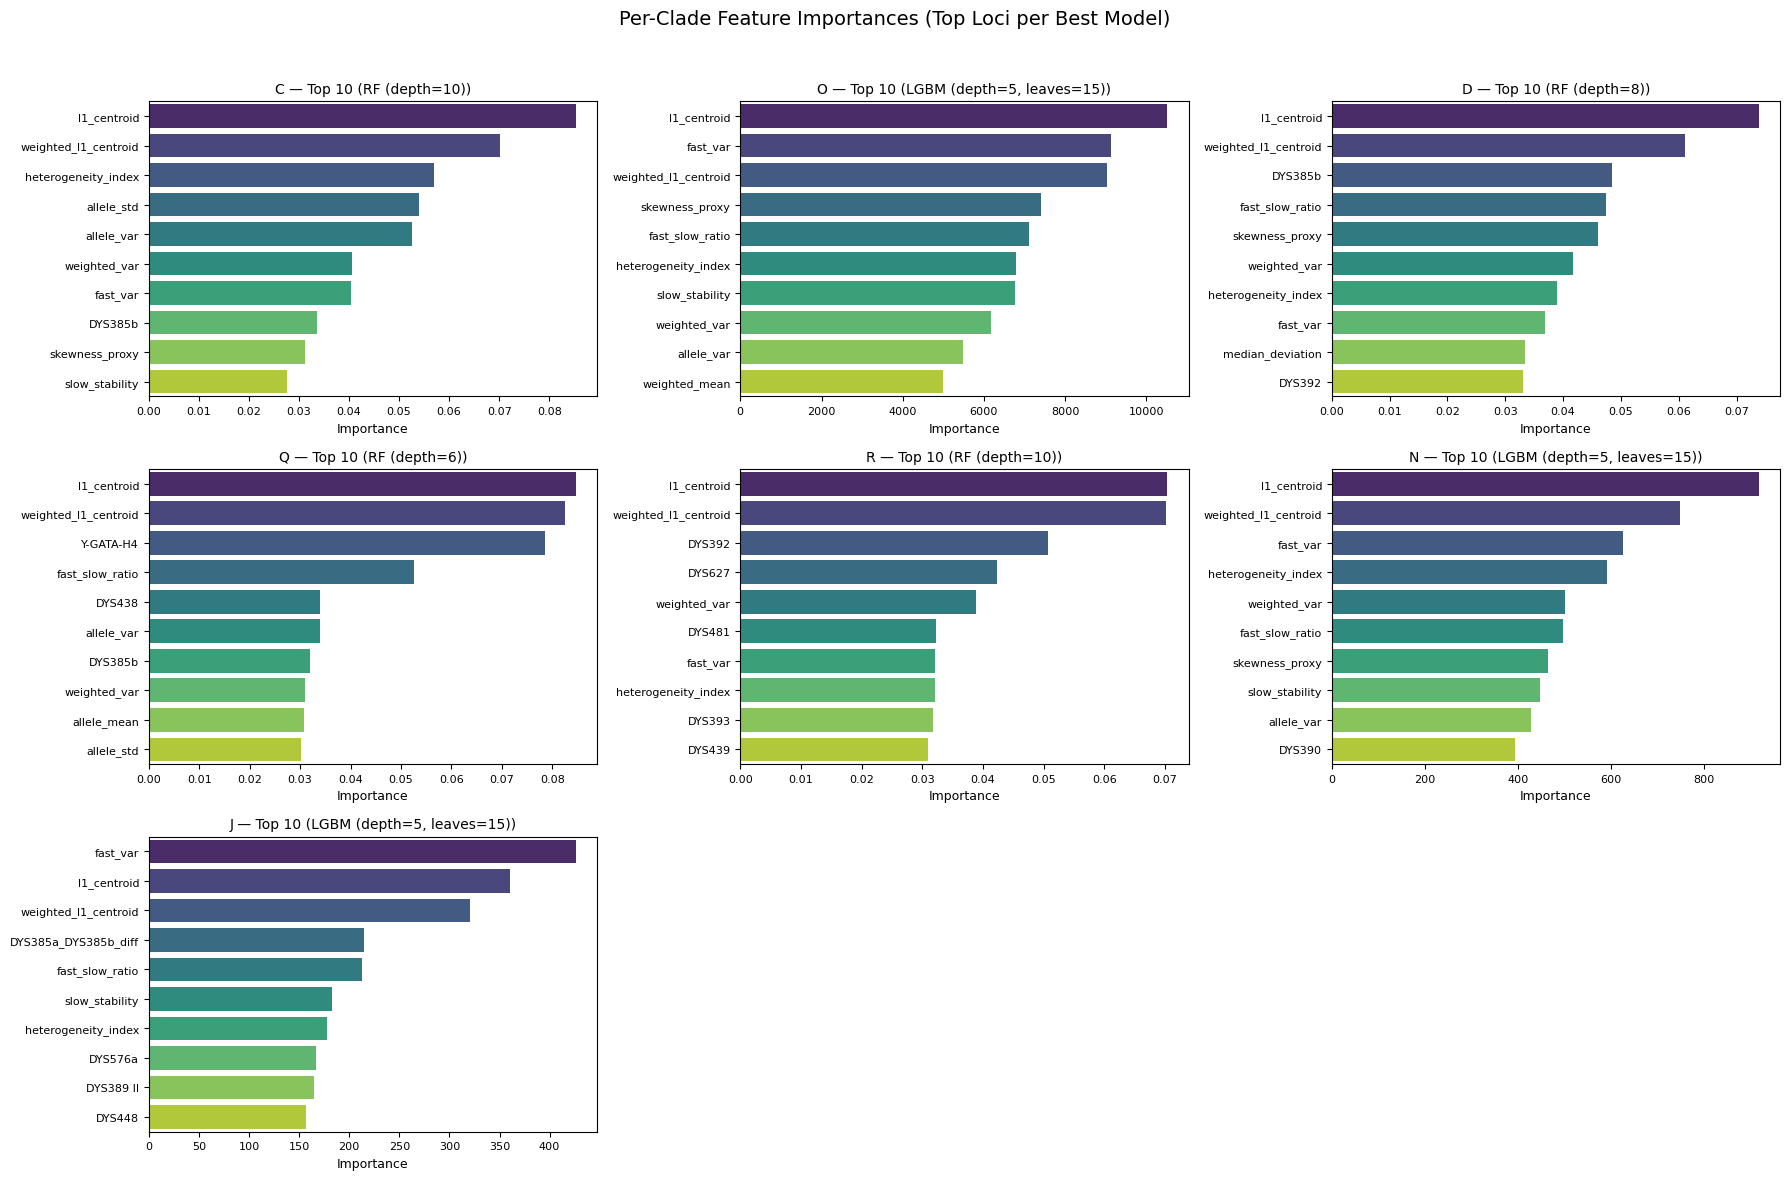

In [15]:
# ======================================================
# 7️⃣ IMPROVED PER-CLADE FEATURE IMPORTANCE VISUALIZATION (COMPACT CANVAS)
# ======================================================

def plot_feature_importances_canvas(sub_results_df, df, hap_col, n=10):
    """Plots top-n feature importances for each major clade in a single canvas."""

    # Prepare a list of clades to plot
    clades_to_plot = [
        c for c in sub_results_df["Clade"]
        if sub_results_df.loc[sub_results_df["Clade"] == c, "n_samples"].values[0] >= 20
    ]
    num_clades = len(clades_to_plot)

    if num_clades == 0:
        print("⚠️ No eligible clades to plot.")
        return

    # Determine subplot grid layout
    cols = 3
    rows = math.ceil(num_clades / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for ax_idx, clade in enumerate(clades_to_plot):
        ax = axes[ax_idx]

        row = sub_results_df[sub_results_df["Clade"] == clade].iloc[0]
        sub_df = df[df["major_clade"] == clade]
        sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors='coerce')
        sub_y = sub_df[hap_col]

        # Skip small ones again just in case
        if sub_y.nunique() < 3 or len(sub_y) < 20:
            ax.axis("off")
            continue

        # Select the better model per clade
        use_rf = row["RF_F1_Test"] >= row["LGBM_F1_Test"]

        if use_rf:
            best_params = row["RF_Params"]
            model_name = f"RF (depth={best_params['max_depth']})"
            model = RandomForestClassifier(
                n_estimators=300,
                max_depth=best_params["max_depth"],
                min_samples_leaf=best_params["min_samples_leaf"],
                min_samples_split=10,
                max_features="sqrt",
                class_weight="balanced",
                n_jobs=-1,
                random_state=42
            )
        else:
            best_params = row["LGBM_Params"]
            model_name = (
                f"LGBM (depth={best_params['max_depth']}, "
                f"leaves={best_params['num_leaves']})"
            )
            model = LGBMClassifier(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=best_params["max_depth"],
                num_leaves=best_params["num_leaves"],
                min_data_in_leaf=best_params["min_data_in_leaf"],
                reg_lambda=best_params["reg_lambda"],
                reg_alpha=best_params["reg_alpha"],
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                is_unbalance=True,
                n_jobs=-1,
                random_state=42,
                verbose=-1
            )

        # Fit model and extract top features
        model.fit(sub_X, sub_y)

        if hasattr(model, "feature_importances_"):
            importances = pd.Series(model.feature_importances_, index=sub_X.columns)
            top_feats = importances.sort_values(ascending=False).head(n)
        else:
            ax.text(0.5, 0.5, "No importances", ha="center", va="center")
            ax.axis("off")
            continue

        # --- Fixed palette deprecation ---
        sns.barplot(
            x=top_feats.values,
            y=top_feats.index,
            hue=top_feats.index,        # <-- fixes palette warning
            legend=False,
            palette="viridis",
            ax=ax
        )

        ax.set_title(f"{clade} — Top {n} ({model_name})", fontsize=10)
        ax.set_xlabel("Importance", fontsize=9)
        ax.set_ylabel("")
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Turn off any extra subplots
    for j in range(ax_idx + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("Per-Clade Feature Importances (Top Loci per Best Model)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# ======================================================
# 8️⃣ EXECUTE VISUALIZATION
# ======================================================
plot_feature_importances_canvas(sub_results_df, df, hap_col, n=10)

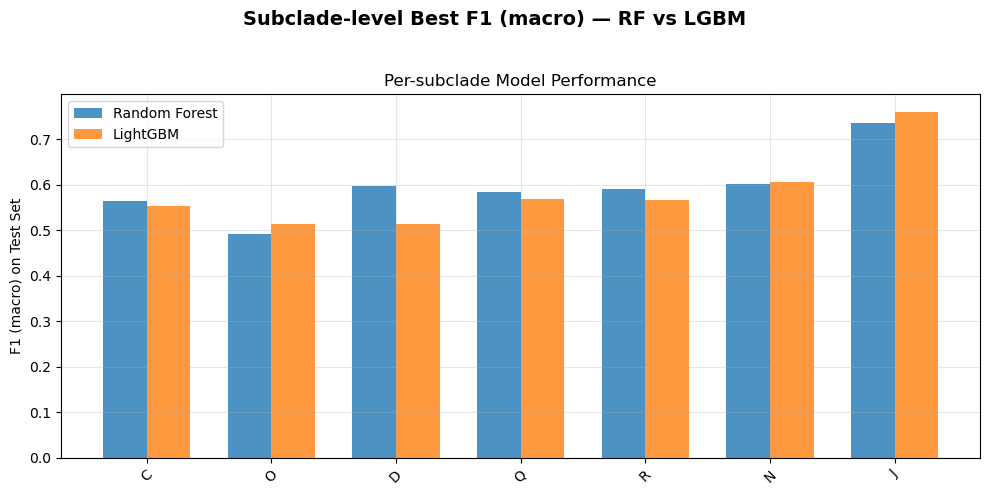

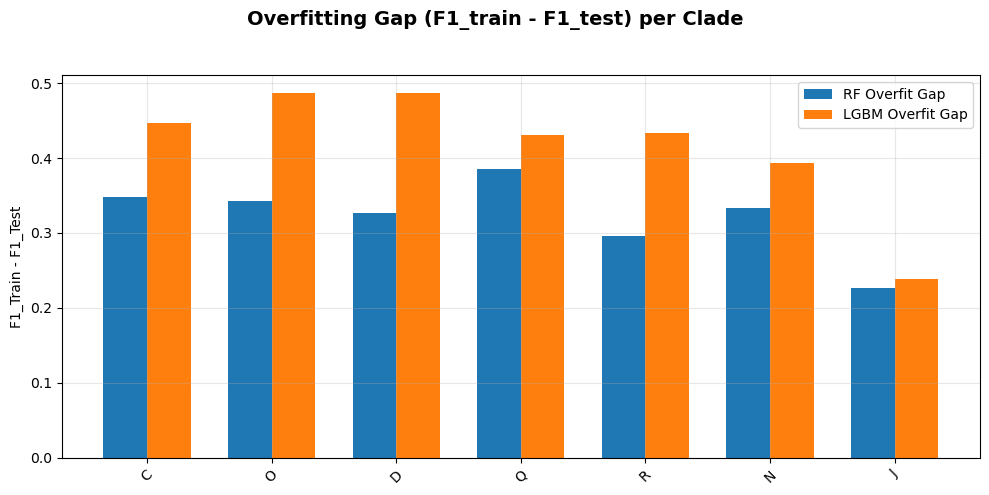

In [16]:
# ======================================================
# 🔍 VISUALIZE SUBCLADE PERFORMANCE & BEST PARAMS
# ======================================================

plt.figure(figsize=(10, 5))
plt.suptitle("Subclade-level Best F1 (macro) — RF vs LGBM", fontsize=14, weight="bold")

# --- Bar chart comparing best test F1 per clade ---
x = np.arange(len(sub_results_df))
bar_width = 0.35

plt.bar(x - bar_width/2, sub_results_df["RF_F1_Test"], width=bar_width, label="Random Forest", alpha=0.8)
plt.bar(x + bar_width/2, sub_results_df["LGBM_F1_Test"], width=bar_width, label="LightGBM", alpha=0.8)

plt.xticks(x, sub_results_df["Clade"], rotation=45)
plt.ylabel("F1 (macro) on Test Set")
plt.title("Per-subclade Model Performance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Overfitting gap plot ---
plt.figure(figsize=(10, 5))
plt.suptitle("Overfitting Gap (F1_train - F1_test) per Clade", fontsize=14, weight="bold")

plt.bar(x - bar_width/2, sub_results_df["RF_Overfit"], width=bar_width, label="RF Overfit Gap")
plt.bar(x + bar_width/2, sub_results_df["LGBM_Overfit"], width=bar_width, label="LGBM Overfit Gap")
plt.xticks(x, sub_results_df["Clade"], rotation=45)
plt.ylabel("F1_Train - F1_Test")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [17]:
# ======================================================
# 🔍 Sample Size vs Depth with F1 as Bubble Size
# ======================================================

plt.figure(figsize=(9, 6))
plt.suptitle("Subclade Sample Size vs Best Model Depth (Bubble = Test F1)", fontsize=14, weight="bold")

# Scale bubble sizes for visibility
rf_sizes = sub_results_df["RF_F1_Test"] * 800
lgbm_sizes = sub_results_df["LGBM_F1_Test"] * 800

# --- Random Forest ---
plt.scatter(sub_results_df["n_samples"], sub_results_df["RF_Depth"],
            s=rf_sizes, color="blue", alpha=0.6, label="Random Forest")

# --- LightGBM ---
plt.scatter(sub_results_df["n_samples"], sub_results_df["LGBM_Depth"],
            s=lgbm_sizes, color="orange", alpha=0.6, label="LightGBM")

# --- Annotate clades ---
for _, row in sub_results_df.iterrows():
    plt.text(row["n_samples"] + 10, row["RF_Depth"] + 0.15, row["Clade"], fontsize=9, color="gray")

plt.xlabel("Number of Samples per Subclade")
plt.ylabel("Best Depth (max_depth)")
plt.title("Relationship Between Subclade Size, Depth, and Performance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

KeyError: 'RF_Depth'

<Figure size 900x600 with 0 Axes>

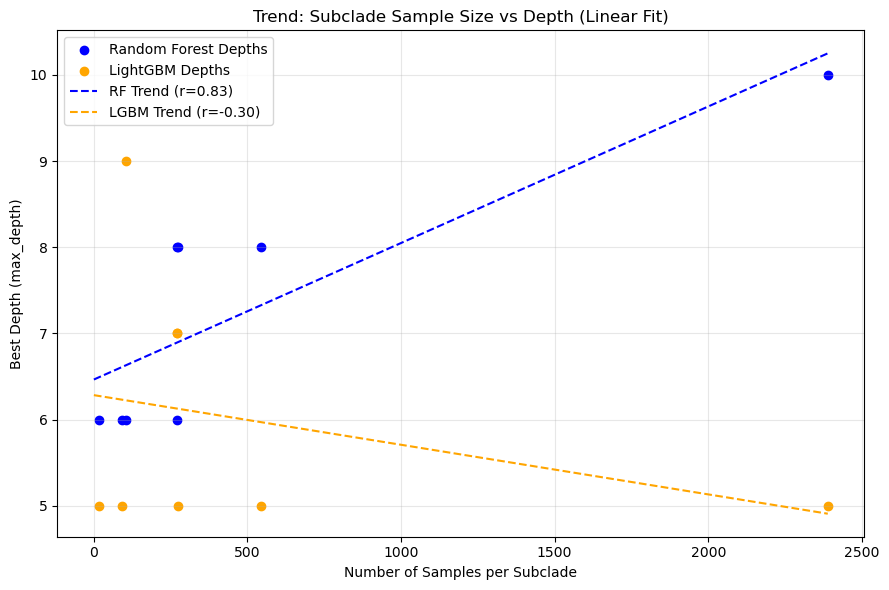

In [ ]:
# ======================================================
# 📈 TREND LINE + CORRELATION ANALYSIS
# ======================================================
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data (drop NaNs)
rf_mask = sub_results_df["RF_Depth"].notna()
lgbm_mask = sub_results_df["LGBM_Depth"].notna()

X_rf = sub_results_df.loc[rf_mask, ["n_samples"]].values
y_rf = sub_results_df.loc[rf_mask, "RF_Depth"].values
X_lgbm = sub_results_df.loc[lgbm_mask, ["n_samples"]].values
y_lgbm = sub_results_df.loc[lgbm_mask, "LGBM_Depth"].values

# Fit simple linear models
rf_fit = LinearRegression().fit(X_rf, y_rf)
lgbm_fit = LinearRegression().fit(X_lgbm, y_lgbm)

# Plot trend lines
x_range = np.linspace(0, sub_results_df["n_samples"].max(), 100).reshape(-1, 1)
plt.figure(figsize=(9, 6))
plt.title("Trend: Subclade Sample Size vs Depth (Linear Fit)")
plt.scatter(X_rf, y_rf, color="blue", label="Random Forest Depths")
plt.scatter(X_lgbm, y_lgbm, color="orange", label="LightGBM Depths")
plt.plot(x_range, rf_fit.predict(x_range), "b--", label=f"RF Trend (r={np.corrcoef(X_rf[:,0], y_rf)[0,1]:.2f})")
plt.plot(x_range, lgbm_fit.predict(x_range), "orange", linestyle="--",
         label=f"LGBM Trend (r={np.corrcoef(X_lgbm[:,0], y_lgbm)[0,1]:.2f})")
plt.xlabel("Number of Samples per Subclade")
plt.ylabel("Best Depth (max_depth)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

,Depth,RF_F1_Train,RF_F1_Test,LGBM_F1_Train,LGBM_F1_Test,RF_Overfit,LGBM_Overfit
0,3.0,0.640150,0.533905,1.0,0.813230,0.106245,0.186770
1,5.0,0.910053,0.748468,1.0,0.748714,0.161585,0.251286
2,7.0,0.972726,0.797239,1.0,0.749379,0.175486,0.250621
3,9.0,0.979191,0.820203,1.0,0.749379,0.158987,0.250621
4,11.0,0.980674,0.821222,1.0,0.747820,0.159453,0.252180
5,13.0,0.981097,0.821885,1.0,0.749379,0.159212,0.250621
6,15.0,0.981312,0.822078,1.0,0.749379,0.159234,0.250621
7,NaN,0.981312,0.822696,1.0,0.749379,0.158616,0.250621


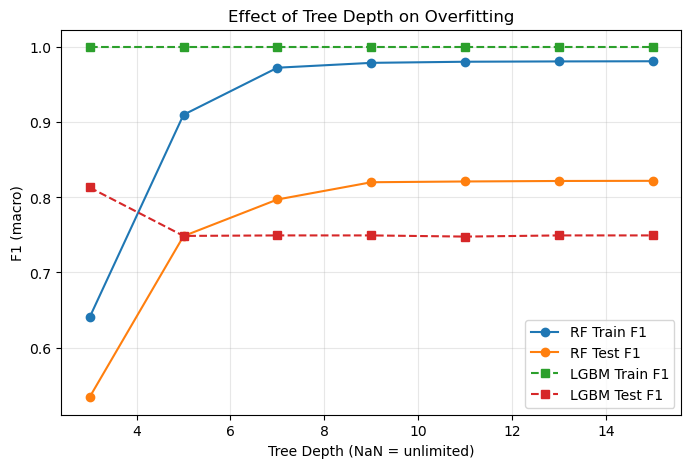

In [ ]:
# ======================================================
# 🔎 DEPTH SENSITIVITY ANALYSIS (Fixed for plotting)
# ======================================================

depth_range = [3, 5, 7, 9, 11, 13, 15, None]  # Try progressively deeper trees
results = []

for depth in depth_range:
    # --- Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=depth,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred_rf_train = rf.predict(X_train)
    y_pred_rf_test = rf.predict(X_test)
    rf_f1_train = f1_score(y_train, y_pred_rf_train, average="macro")
    rf_f1_test = f1_score(y_test, y_pred_rf_test, average="macro")

    # --- LightGBM ---
    lgbm = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31 if depth is None else min(2 ** depth // 2, 31),
        max_depth=-1 if depth is None else depth,
        min_data_in_leaf=10,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        reg_lambda=1.0,
        reg_alpha=0.5,
        is_unbalance=True,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    lgbm.fit(X_train, y_train)
    y_pred_lgbm_train = lgbm.predict(X_train)
    y_pred_lgbm_test = lgbm.predict(X_test)
    lgbm_f1_train = f1_score(y_train, y_pred_lgbm_train, average="macro")
    lgbm_f1_test = f1_score(y_test, y_pred_lgbm_test, average="macro")

    results.append({
        "Depth": depth if depth is not None else np.nan,  # ✅ use np.nan instead of string
        "RF_F1_Train": rf_f1_train,
        "RF_F1_Test": rf_f1_test,
        "LGBM_F1_Train": lgbm_f1_train,
        "LGBM_F1_Test": lgbm_f1_test,
        "RF_Overfit": rf_f1_train - rf_f1_test,
        "LGBM_Overfit": lgbm_f1_train - lgbm_f1_test
    })

# --- Summarize results ---
depth_df = pd.DataFrame(results)
display(depth_df)

# --- Clean and prepare for plotting ---
depth_df["Depth"] = depth_df["Depth"].astype(float)

# ======================================================
# 📈 Plot depth vs F1 for visual clarity
# ======================================================
plt.figure(figsize=(8, 5))
plt.plot(depth_df["Depth"], depth_df["RF_F1_Train"], 'o-', label="RF Train F1")
plt.plot(depth_df["Depth"], depth_df["RF_F1_Test"], 'o-', label="RF Test F1")
plt.plot(depth_df["Depth"], depth_df["LGBM_F1_Train"], 's--', label="LGBM Train F1")
plt.plot(depth_df["Depth"], depth_df["LGBM_F1_Test"], 's--', label="LGBM Test F1")

plt.xlabel("Tree Depth (NaN = unlimited)")
plt.ylabel("F1 (macro)")
plt.title("Effect of Tree Depth on Overfitting")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

visualize overfitting

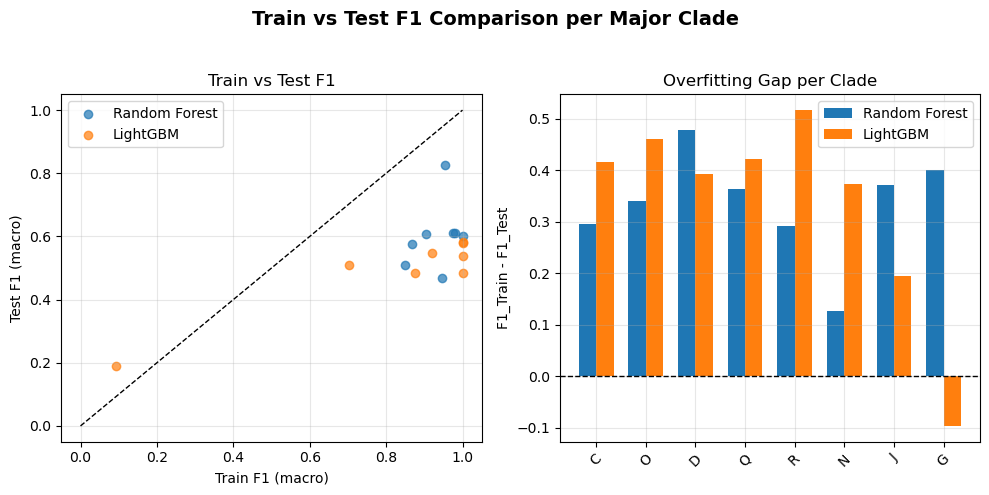

In [ ]:
# ======================================================
# 7️⃣ VISUALIZE OVERFITTING (Train vs Test F1)
# ======================================================

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.suptitle("Train vs Test F1 Comparison per Major Clade", fontsize=14, weight="bold")

# --- Scatter: Train vs Test ---
plt.subplot(1, 2, 1)
plt.scatter(sub_results_df["RF_F1_Train"], sub_results_df["RF_F1_Test"], label="Random Forest", alpha=0.7)
plt.scatter(sub_results_df["LGBM_F1_Train"], sub_results_df["LGBM_F1_Test"], label="LightGBM", alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("Train F1 (macro)")
plt.ylabel("Test F1 (macro)")
plt.title("Train vs Test F1")
plt.legend()
plt.grid(alpha=0.3)

# --- Bar: Overfitting Gap ---
plt.subplot(1, 2, 2)
bar_width = 0.35
x = np.arange(len(sub_results_df))
plt.bar(x - bar_width/2, sub_results_df["RF_Overfit"], width=bar_width, label="Random Forest")
plt.bar(x + bar_width/2, sub_results_df["LGBM_Overfit"], width=bar_width, label="LightGBM")
plt.axhline(0, color='k', linestyle='--', lw=1)
plt.xticks(x, sub_results_df["Clade"], rotation=45)
plt.ylabel("F1_Train - F1_Test")
plt.title("Overfitting Gap per Clade")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
cm = confusion_matrix(y_test, y_major_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
plt.figure(figsize=(10,10))
disp.plot(cmap="Blues", xticks_rotation=90, values_format=".0f")
plt.title("Confusion Matrix — N1 Subclades")
plt.show()

NameError: name 'y_major_pred' is not defined

<b>Discussion</b>

Consider doing a confusion matrix?? For random forest, check where mistakes/confusions were made

Note:
- kNN is more suited for data with non-linear relationships
- Logistic Regression is more suited for binary classification problems, and assumes linearity between the dependent variable and independent variables
- SVM is more suited for datasets with no overlapping classes
- LDA is more suited for multi-class data classifications since it projects data into one dimension for easier classification (i.e. dimensionality reduction)
- Gaussian Naive Bayes is more suited for continuous data as it assumes the values follow a normal distribution
- Decision Tree and Random Forest are more suited for rule based problems, and handling discrete data
- GBM is prone to overfitting

# Recommendations

# References

[1] https://www.sciencedirect.com/science/article/abs/pii/S0379073824001944

[2] https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35/#:~:text=IN%20DEPTH%20ANALYSIS,scaling%20in%20the%20X%2DY%20plane.

[3] https://www.geeksforgeeks.org/machine-learning/Feature-Engineering-Scaling-Normalization-and-Standardization/

[4] https://www.geeksforgeeks.org/data-science/advantages-and-disadvantages-of-logistic-regression/

[5] https://medium.com/@haj122/when-and-when-not-to-use-svms-e9edea04d6ba